# ML - Problem Set 1: Predicting Income

In [1]:
# ----------------------------------------------------------------------
# Instala librerias
# ----------------------------------------------------------------------

In [2]:
# ----------------------------------------------------------------------
# Importar librerias
# ----------------------------------------------------------------------
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.impute import SimpleImputer

## 2. Data

In [ ]:
# ----------------------------------------------------------------------
# Adquisición de datos
# ----------------------------------------------------------------------
base_url = "https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_{}.html"
all_data = []

for i in range(1, 11):  # Iterar sobre las 10 páginas
    url = base_url.format(i)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extraer la tabla de la página
    table = soup.find('table')
    if table:
        # Encabezados de la tabla
        headers = [th.text.strip() for th in table.find_all('th')]

        # Filas de la tabla
        rows = [
            [cell.text.strip() for cell in row.find_all('td')]
            for row in table.find_all('tr')[1:]  # Excluir encabezado
        ]

        # Crear un DataFrame para la página actual
        df = pd.DataFrame(rows, columns=headers)
        all_data.append(df)

# Concatenar todos los DataFrames en uno solo
final_data = pd.concat(all_data, ignore_index=True)

# Guardar en un archivo CSV
final_data.to_csv("geih_2018_bogota.csv", index=False)

In [6]:
# ----------------------------------------------------------------------
# Cargar y limpiar datos
# ----------------------------------------------------------------------

# Cargar el archivo CSV previamente almacenado
final_data = pd.read_csv("geih_2018_bogota.csv") #se toma del csv para poder procesarlo sin que se agote la memoria RAM

# Función para limpiar los datos
def clean_data(df):
    df['y_salary_m'] = pd.to_numeric(df['y_salary_m'], errors='coerce')
    filtered = df[
        (df['age'].astype(float) > 18) &
        (df['ocu'].astype(float) == 1) &
        (df['y_salary_m'] > 0) &
        df['y_salary_m'].notnull()
    ]
    filtered['hourly_wage'] = filtered['y_salary_m'].astype(float) / filtered['hoursWorkUsual'].astype(float)
    filtered = filtered.dropna(subset=['hourly_wage', 'age', 'sex', 'maxEducLevel'])


    # Seleccionar una muestra del 5% para reducir tamaño (para poder correr el modelo)
    filtered = filtered.sample(frac=0.05, random_state=123)

    # Convertir variables categóricas
    categorical_columns = filtered.select_dtypes(include=['object']).columns
    return pd.get_dummies(filtered, columns=categorical_columns, drop_first=True)

# Aplicar la limpieza de datos
filtered_data = clean_data(final_data)

<ipython-input-6-dc1f0a26ed91>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['hourly_wage'] = filtered['y_salary_m'].astype(float) / filtered['hoursWorkUsual'].astype(float)


## Predicting wages


Resultados de RMSE para cada modelo:
Linear Regression: RMSE = 0.01
Polynomial Regression (degree=2): RMSE = 65550.05
Decision Tree (max_depth=5): RMSE = 12709.61
Random Forest (n_estimators=50): RMSE = 6894.06
Gradient Boosting: RMSE = 3664.13

Mejor modelo: Linear Regression


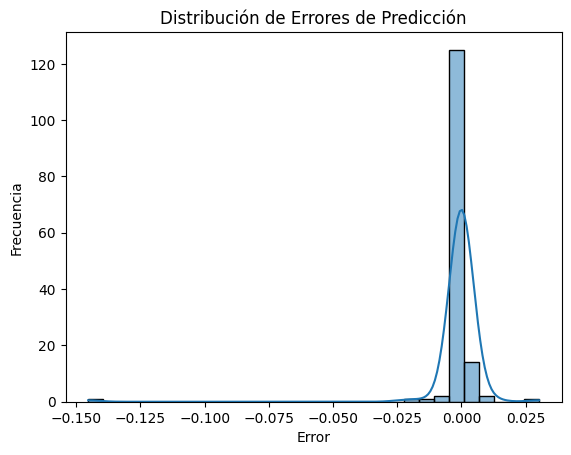

In [7]:
# ----------------------------------------------------------------------
# Modelado y evaluación
# ----------------------------------------------------------------------
X = filtered_data.drop(columns=['hourly_wage'])
y = filtered_data['hourly_wage']

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Eliminar columnas con solo NaN en el conjunto de entrenamiento
nan_columns = X_train.columns[X_train.isnull().all()]
X_train = X_train.drop(columns=nan_columns)
X_test = X_test.drop(columns=nan_columns)  # Asegurarse de que ambas matrices coincidan

# Imputar valores faltantes con la mediana
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Modelos a evaluar
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (degree=2)": PolynomialFeatures(degree=2),
    "Decision Tree (max_depth=5)": DecisionTreeRegressor(max_depth=5),
    "Random Forest (n_estimators=50)": RandomForestRegressor(n_estimators=50, random_state=123),
    "Gradient Boosting": GradientBoostingRegressor(random_state=123)
}

results = {}

for name, model in models.items():
    if "Polynomial" in name:
        # Preprocesar las características para la regresión polinómica
        poly = PolynomialFeatures(degree=2)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Ajustar modelo de regresión lineal con las características polinómicas
        linear_poly = LinearRegression()
        linear_poly.fit(X_train_poly, y_train)
        y_pred = linear_poly.predict(X_test_poly)

        # Calcular RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = rmse
    else:
        # Otros modelos
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calcular RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = rmse

# Resultados
print("\nResultados de RMSE para cada modelo:")
for model, error in results.items():
    print(f"{model}: RMSE = {error:.2f}")

# Mejor modelo y errores
best_model_name = min(results, key=results.get)
print(f"\nMejor modelo: {best_model_name}")

# Calcular errores de predicción
if "Polynomial" in best_model_name:
    errors = y_test - linear_poly.predict(X_test_poly)
else:
    errors = y_test - models[best_model_name].predict(X_test)

# Visualización de errores
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribución de Errores de Predicción')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [8]:
# ----------------------------------------------------------------------
# Validación cruzada K-Fold
# ----------------------------------------------------------------------

# Eliminar columnas con todos los valores NaN
X = X.dropna(axis=1, how='all')

# Imputar valores faltantes en X completo antes de la validación cruzada
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Validación cruzada K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=123)

print("\nResultados de K-Fold (5-fold):")
for model_name in sorted(results, key=results.get)[:2]:
    model = models[model_name]
    scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_kfold = np.sqrt(-scores.mean())
    print(f"{model_name} (K-Fold): RMSE = {rmse_kfold:.2f}")


Resultados de K-Fold (5-fold):
Linear Regression (K-Fold): RMSE = 24.16
Gradient Boosting (K-Fold): RMSE = 14444.88
